In [1]:
# All purpose library
import pandas as pd
import numpy as np

# Preprocessing library
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML library
from sklearn.model_selection import train_test_split
from prophet import Prophet

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Ignoring Warning during trainings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data from file and convert the date and time columns into one column
df = pd.read_csv('data/household_power_consumption.txt', sep=';', header =0, parse_dates=[['Date', 'Time']])

In [3]:
# Check for missing values
df.isna().values.any()

True

In [4]:
# Replace ? with nan
df.replace('?', np.nan, inplace=True)

In [5]:
exclude = ['Date_Time']
df = df.set_index(exclude, append=True).astype(float).reset_index(exclude)

In [6]:
# The active energy consumed every minute (in watt hour) in the household by electrical 
# equipment not measured in sub-meterings 1, 2 and 3. This will sub-metering 4
df['Sub_metering_4'] = (df['Global_active_power']*1000/60) - \
    (df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3'])

#### Question 11

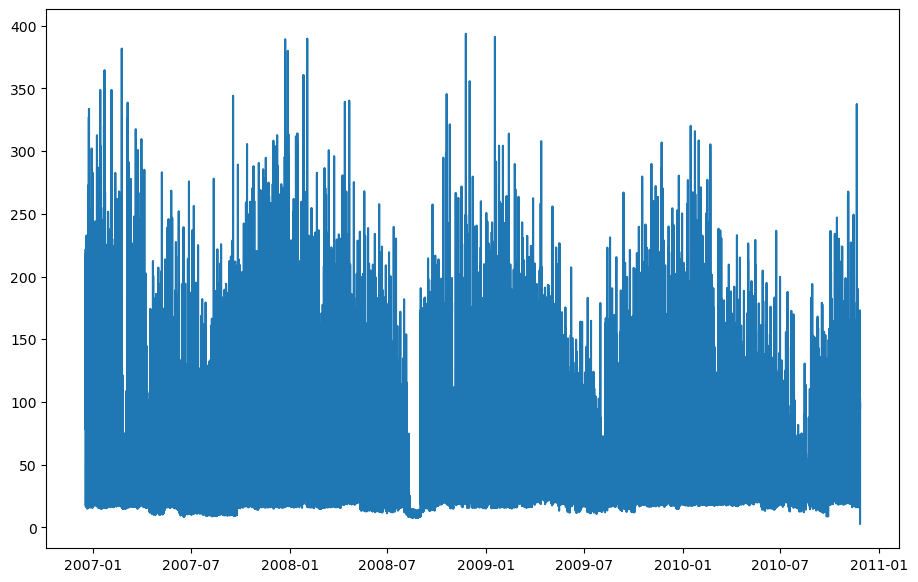

In [7]:
# Filling missing data by imputation - Backward fil
df_ffill = df.fillna(method='ffill')

df_ffill = df_ffill.set_index(['Date_Time'])
df_hourly = df_ffill.resample('60Min').sum()

plt.figure(figsize=(11,7))
plt.plot(df_hourly['Global_active_power'])

#### Question 12

In [8]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df_hourly['Global_active_power'], df_hourly['Voltage'])
print('Pearsons correlation: {:.3f}'.format(corr))

Pearsons correlation: -0.341


#### Question 13

In [9]:

corr, _ = pearsonr(df_hourly['Voltage'], df_hourly['Global_intensity'])
print('Pearsons correlation: {:.2f}'.format(corr))

Pearsons correlation: -0.35


#### Question 14

In [10]:
df_daily = df_ffill.resample('D').sum()
daily_data = df_daily.reset_index().rename({'Date_Time':'ds', 'Global_active_power':'y'}, axis=1)

# Divide the data into train and test sets
train_size = (len(df_daily) - 300)
train_data = daily_data[:train_size]
test_data = daily_data[train_size:]

# Instantiate fb prophet to train a Univariate time series modeling
univariate_model = Prophet()

# Fit model
univariate_model.fit(train_data)

future = univariate_model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = univariate_model.predict(future)

16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
  return (np.mean(np.abs((y_true - y_pred) / y_true))) * 100
    
y_true = test_data['y'].values
y_pred = forecast['yhat'][train_size:].values

# MAPE of multivariate model
mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print('MAPE of univariate model: {:.2f}'.format(mape)) 

MAPE of univariate model: 27.19


#### Question 15

In [12]:
# RMSE of univariate model
rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print('RMSE of univariate model: {:.2f}'.format(rmse))

RMSE of univariate model: 401.82


#### Question 16

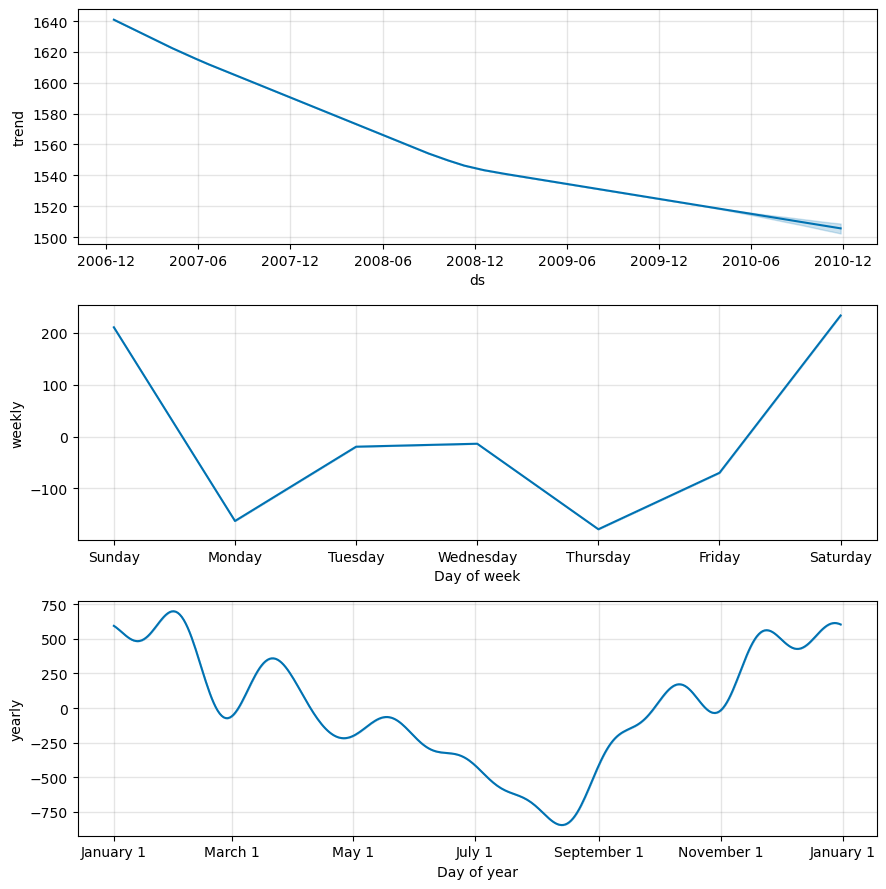

In [13]:
# Plot components of the forecast
f = univariate_model.plot_components(forecast)
plt.show()

#### Question 17

In [14]:
daily_data2 = df_daily.reset_index().rename({'Date_Time':'ds', 'Global_active_power':'y', 'Global_reactive_power':'add1',
                         'Voltage':'add2', 'Global_intensity':'add3', 'Sub_metering_1':'add4', 
                         'Sub_metering_2':'add5', 'Sub_metering_3':'add6'}, axis=1)

# Divide the data into train and test sets
train_data2 = daily_data2[:train_size]
test_data2 = daily_data2[train_size:]

# Instantiates a new fb prophet model


multivariate_model = Prophet()

# Add regressors to the model
multivariate_model.add_regressor('add1')
multivariate_model.add_regressor('add2')
multivariate_model.add_regressor('add3')
multivariate_model.add_regressor('add4')
multivariate_model.add_regressor('add5')
multivariate_model.add_regressor('add6')

# Fit model
multivariate_model.fit(train_data2)

# Make future dataframe for forecasting
future2 = multivariate_model.make_future_dataframe(periods=len(test_data2), freq='D')

future2['add1'] = daily_data2['add1']
future2['add2'] = daily_data2['add2']
future2['add3'] = daily_data2['add3']
future2['add4'] = daily_data2['add4']
future2['add5'] = daily_data2['add5']
future2['add6'] = daily_data2['add6']

forecast2 = multivariate_model.predict(future2)


y_true = test_data2['y'].values
y_pred = forecast2['yhat'][train_size:].values

# MAPE of multivariate model
mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print('MAPE of multivariate model: {:.2f}'.format(mape)) 

16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE of multivariate model: 2.57


#### Question 18

In [15]:
# RMSE of multivariate model
rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print('RMSE of multivariate model: {:.2f}'.format(rmse))

RMSE of multivariate model: 34.79


#### Question 19 & 20

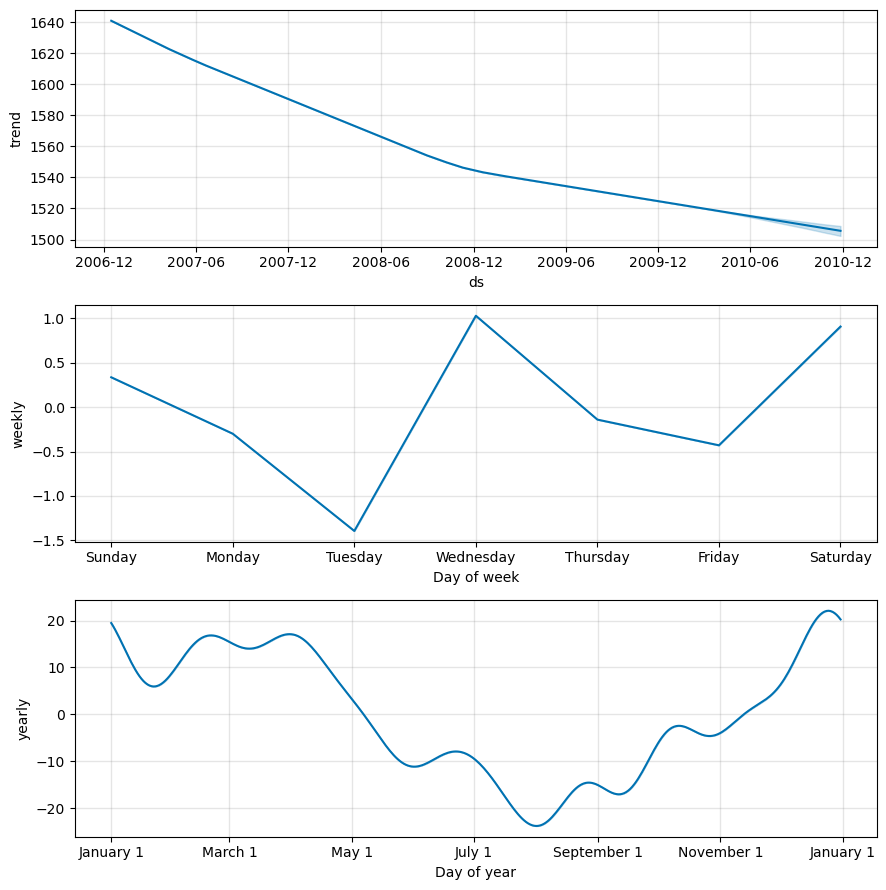

In [16]:
# Plot components of the forecast
f = multivariate_model.plot_components(forecast)
plt.show()